# KAGGLE CATS vs DOGS CHALLENGE
- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## imports & data setup

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import log_loss

In [3]:
from pathlib import Path

### gpu check

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
batch_size = 32

In [7]:
path = Path('./data')

In [8]:
path.ls()

[PosixPath('data/test'),
 PosixPath('data/train'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/models')]

In [9]:
(path/'train').ls()[:10]

[PosixPath('data/train/cat.10146.jpg'),
 PosixPath('data/train/cat.3191.jpg'),
 PosixPath('data/train/dog.11318.jpg'),
 PosixPath('data/train/cat.11012.jpg'),
 PosixPath('data/train/dog.7140.jpg'),
 PosixPath('data/train/dog.9303.jpg'),
 PosixPath('data/train/cat.2979.jpg'),
 PosixPath('data/train/dog.10655.jpg'),
 PosixPath('data/train/cat.8605.jpg'),
 PosixPath('data/train/dog.1524.jpg')]

In [10]:
pat = r"(\w+).\d+.jpg$"

In [11]:
fnames = get_image_files(path/'train')
len(fnames)

25000

In [12]:
fnames[:5]

[PosixPath('data/train/cat.10146.jpg'),
 PosixPath('data/train/cat.3191.jpg'),
 PosixPath('data/train/dog.11318.jpg'),
 PosixPath('data/train/cat.11012.jpg'),
 PosixPath('data/train/dog.7140.jpg')]

In [13]:
len((path/'train').ls())

25000

In [14]:
tfms = get_transforms()

### load data from filenames

In [15]:
data = (ImageDataBunch
        .from_name_re(path, fnames, pat, valid_pct=.3, size=144, bs=batch_size, ds_tfms=tfms)
        .normalize(imagenet_stats)
       )

In [16]:
data

ImageDataBunch;

Train: LabelList (17500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,cat,dog,dog
Path: data;

Valid: LabelList (7500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,dog,cat,cat
Path: data;

Test: None

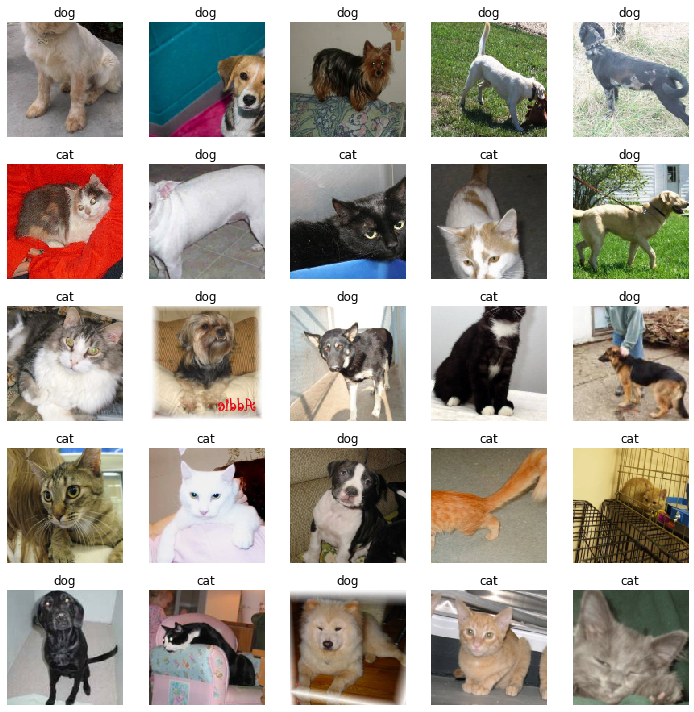

In [17]:
data.show_batch(figsize=(10, 10))

In [17]:
data.classes

['cat', 'dog']

In [18]:
data.c

2

## modeling

In [19]:
learner = cnn_learner(data, models.resnet50, metrics=error_rate)

In [21]:
learner.fit_one_cycle(6)

- WOW!!! a 1.2 error rate on validation 🤯

In [32]:
learner.save('initial_model_low_bs_high_dpi')

In [28]:
interp = ClassificationInterpretation.from_learner(learner)

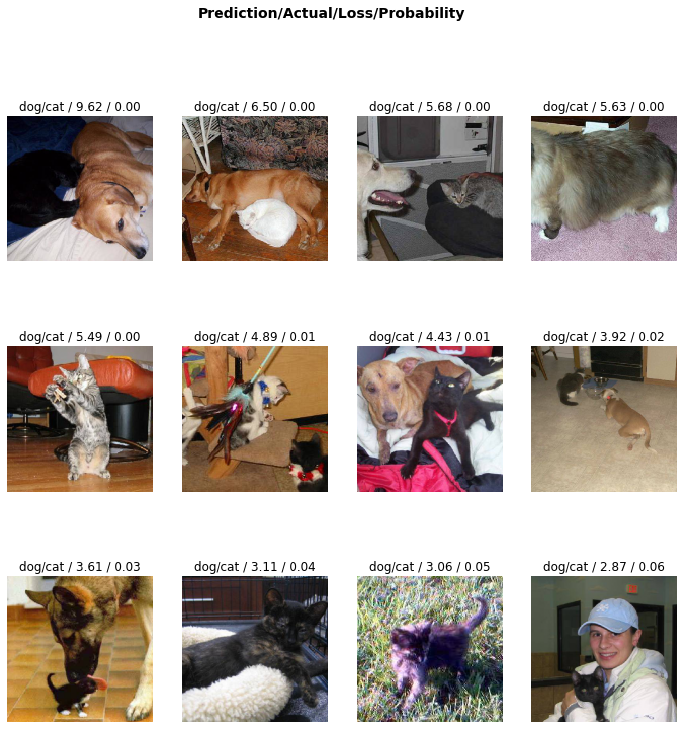

In [29]:
interp.plot_top_losses(12)

- we see that the _struggle is real_. Most of the pics have dogs ***and*** cats and thus confusing the classifier.
- since the competition needs probabilities and it is possible that both of the categories appear in a picture, may be 
  we can classify this as a multilabel classification problem rather than binary.

In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


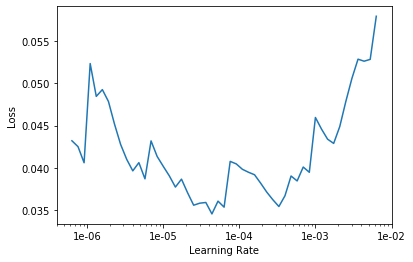

In [27]:
learner.recorder.plot();

- rate of decrease is more in the region `(1e-6, 1e-5)`... so we use that for training the whole net

In [34]:
learner.unfreeze()

In [35]:
learner.fit_one_cycle(6, max_lr=slice(1e-6, 1e-5))

In [36]:
learner.save('resnet50_fulltrain_low_bs_high_dpi')

In [37]:
interp = ClassificationInterpretation.from_learner(learner)

In [41]:
interp.most_confused()

[('cat', 'dog', 39), ('dog', 'cat', 30)]

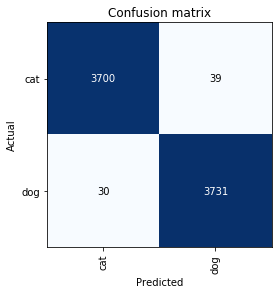

In [42]:
interp.plot_confusion_matrix()

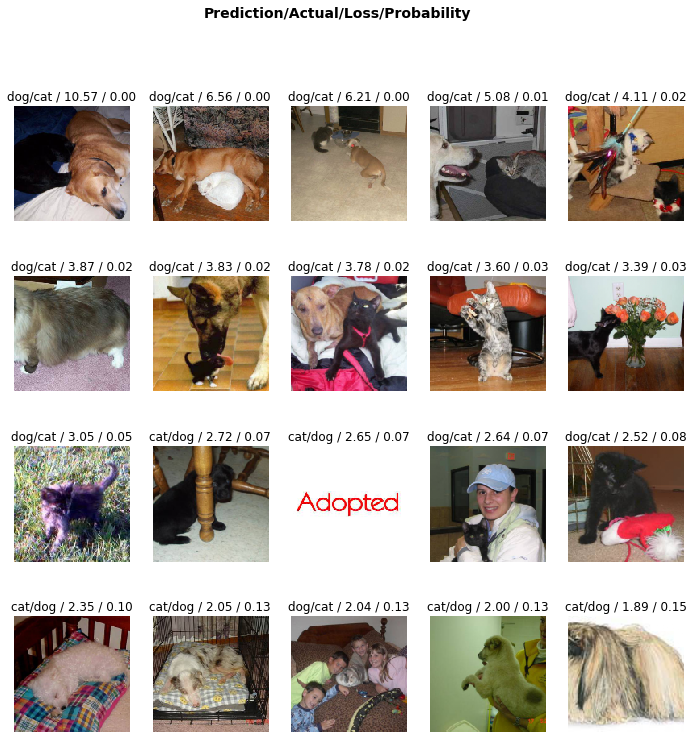

In [45]:
interp.plot_top_losses(20)

## predictions on test dataset

In [20]:
(path/'test').ls()[:3]

[PosixPath('data/test/9127.jpg'),
 PosixPath('data/test/6032.jpg'),
 PosixPath('data/test/3388.jpg')]

In [21]:
data

ImageDataBunch;

Train: LabelList (17500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,cat,dog,dog
Path: data;

Valid: LabelList (7500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,dog,cat,cat
Path: data;

Test: None

In [22]:
data.classes

['cat', 'dog']

In [23]:
# disable scientific mode
torch.set_printoptions(sci_mode=False)

In [24]:
# test images need to be sorted so that we can map the image with its corresponding label
test_imgs = (path/'test/').ls()
test_imgs.sort(key=lambda x: x.stem)

In [25]:
test_imgs[:10]

[PosixPath('data/test/1.jpg'),
 PosixPath('data/test/10.jpg'),
 PosixPath('data/test/100.jpg'),
 PosixPath('data/test/1000.jpg'),
 PosixPath('data/test/10000.jpg'),
 PosixPath('data/test/10001.jpg'),
 PosixPath('data/test/10002.jpg'),
 PosixPath('data/test/10003.jpg'),
 PosixPath('data/test/10004.jpg'),
 PosixPath('data/test/10005.jpg')]

In [26]:
data.add_test(test_imgs)

In [27]:
data

ImageDataBunch;

Train: LabelList (17500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,cat,dog,dog
Path: data;

Valid: LabelList (7500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: CategoryList
cat,cat,dog,cat,cat
Path: data;

Test: LabelList (12500 items)
x: ImageList
Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144),Image (3, 144, 144)
y: EmptyLabelList
,,,,
Path: data

In [31]:
# learner.load('resnet50_fulltrain_low_bs_high_dpi');

In [32]:
interp = ClassificationInterpretation.from_learner(learner)

In [90]:
# use test time augmentation
interp2 = ClassificationInterpretation.from_learner(learner, tta=True)

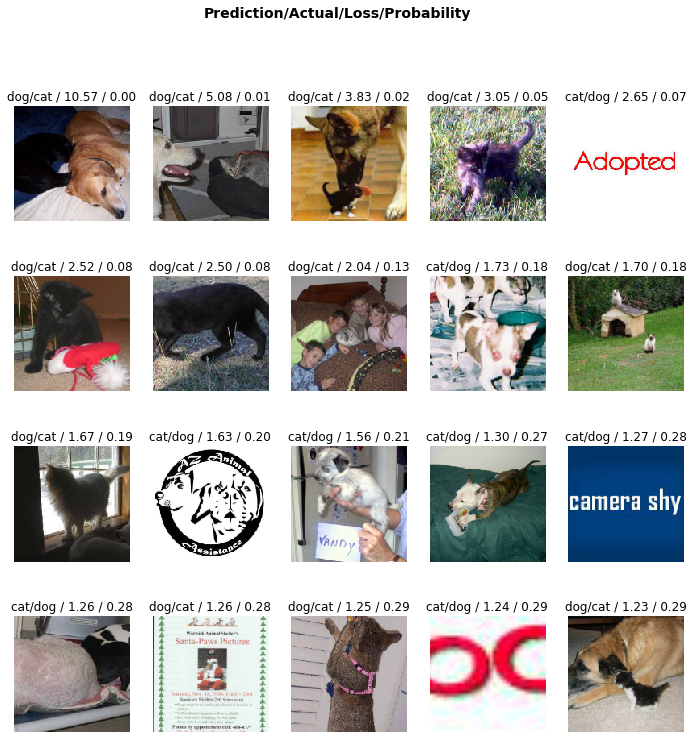

In [33]:
interp.plot_top_losses(20)

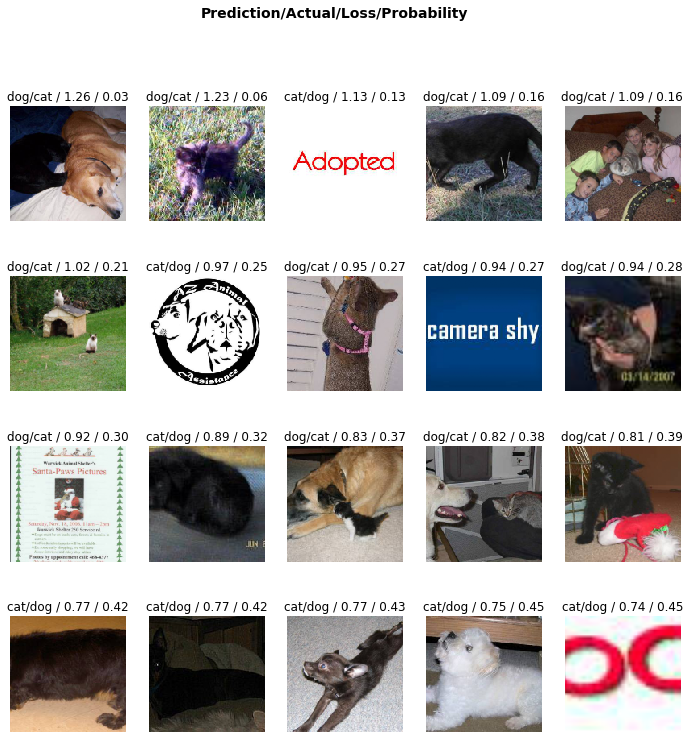

In [91]:
interp2.plot_top_losses(20)

In [92]:
# preds, _ = learner.get_preds(DatasetType.Test)
preds, _ = learner.TTA(ds_type=DatasetType.Test)  # test time augmentation gives you better results

In [93]:
preds.shape

torch.Size([12500, 2])

In [53]:
preds[:20]

tensor([[    0.0001,     0.9999],
        [    0.9984,     0.0016],
        [    0.9999,     0.0001],
        [    0.0000,     1.0000],
        [    0.0005,     0.9995],
        [    1.0000,     0.0000],
        [    0.9970,     0.0030],
        [    0.0000,     1.0000],
        [    0.0161,     0.9839],
        [    0.9996,     0.0004],
        [    1.0000,     0.0000],
        [    0.9996,     0.0004],
        [    0.9999,     0.0001],
        [    1.0000,     0.0000],
        [    0.9996,     0.0004],
        [    0.0000,     1.0000],
        [    0.0000,     1.0000],
        [    1.0000,     0.0000],
        [    0.9532,     0.0468],
        [    0.9827,     0.0173]])

In [95]:
labels = preds.argmax(1)

In [96]:
labels[:20]

tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [97]:
data.test_ds.items[:20]

array([PosixPath('data/test/1.jpg'), PosixPath('data/test/10.jpg'), PosixPath('data/test/100.jpg'),
       PosixPath('data/test/1000.jpg'), PosixPath('data/test/10000.jpg'), PosixPath('data/test/10001.jpg'),
       PosixPath('data/test/10002.jpg'), PosixPath('data/test/10003.jpg'), PosixPath('data/test/10004.jpg'),
       PosixPath('data/test/10005.jpg'), PosixPath('data/test/10006.jpg'), PosixPath('data/test/10007.jpg'),
       PosixPath('data/test/10008.jpg'), PosixPath('data/test/10009.jpg'), PosixPath('data/test/1001.jpg'),
       PosixPath('data/test/10010.jpg'), PosixPath('data/test/10011.jpg'), PosixPath('data/test/10012.jpg'),
       PosixPath('data/test/10013.jpg'), PosixPath('data/test/10014.jpg')], dtype=object)

In [98]:
df = pd.DataFrame({'id': map(lambda x: x.name.split('.')[0], data.test_ds.items), 'label': preds[:, 1], 
                   'animal': labels})
df.shape

(12500, 3)

In [99]:
df.head()

id     label  animal
0      1  0.997595       1
1     10  0.006188       0
2    100  0.006429       0
3   1000  0.989592       1
4  10000  0.998256       1

In [100]:
df.dtypes

id         object
label     float32
animal      int64
dtype: object

In [101]:
data.classes

['cat', 'dog']

In [102]:
df.animal = df.animal.map({0: 'cat', 1:'dog' })

In [103]:
df.head()

id     label animal
0      1  0.997595    dog
1     10  0.006188    cat
2    100  0.006429    cat
3   1000  0.989592    dog
4  10000  0.998256    dog

- check for a few examples if the labels make sense

dog


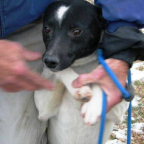

cat


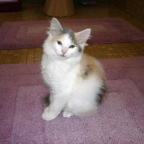

cat


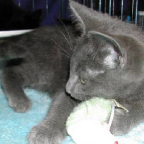

dog


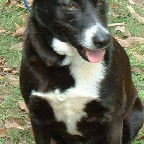

dog


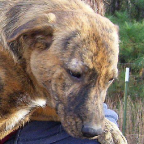

cat


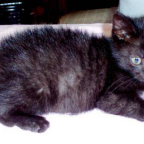

cat


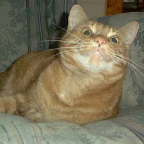

dog


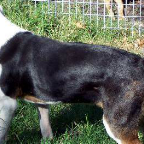

dog


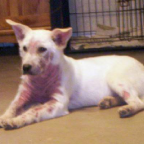

cat


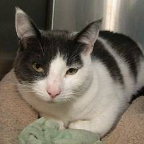

cat


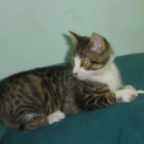

cat


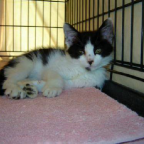

cat


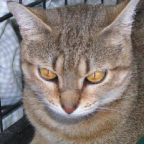

cat


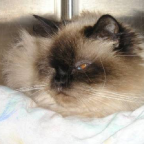

cat


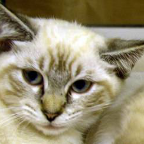

dog


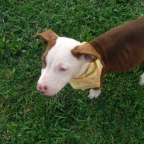

dog


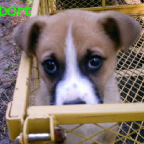

cat


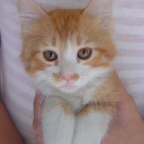

cat


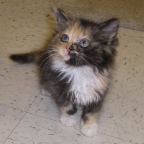

cat


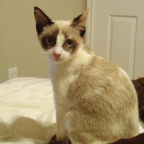

In [104]:
for row, label in enumerate(df.animal.values[:20]):
    print(label)
    display(data.test_ds[row][0])

In [105]:
df

id     label animal
0          1  0.997595    dog
1         10  0.006188    cat
2        100  0.006429    cat
3       1000  0.989592    dog
4      10000  0.998256    dog
...      ...       ...    ...
12495   9995  0.031378    cat
12496   9996  0.999561    dog
12497   9997  0.999646    dog
12498   9998  0.000217    cat
12499   9999  0.002758    cat

[12500 rows x 3 columns]

## submit to LB

In [106]:
df.drop('animal', axis=1).to_csv('submissions.csv', index=None)

# compare LB scores

- let's download the leaderboard scores and see where we fit

In [107]:
lb = pd.read_csv('./dogs-vs-cats-redux-kernels-edition-publicleaderboard.csv')
lb.shape

(4453, 4)

In [108]:
lb = lb.sort_values('Score').reset_index(drop=True)

In [109]:
lb

TeamId          TeamName       SubmissionDate     Score
0     444682        Cocostarcu  2017-03-02 23:43:18   0.03302
1     459493          guangsha  2017-03-01 08:01:34   0.03305
2     444682        Cocostarcu  2017-03-02 18:35:44   0.03314
3     444682        Cocostarcu  2017-03-01 07:33:16   0.03351
4     459493          guangsha  2017-03-01 07:40:01   0.03375
...      ...               ...                  ...       ...
4448  500493  Siddharth Dinesh  2017-02-27 18:31:05  30.34754
4449  392626     Jeremy Howard  2016-10-31 02:33:57  33.37865
4450  396686           tooooom  2016-10-31 22:03:17  33.47261
4451  404862             See--  2016-11-12 22:37:35  33.64114
4452  414591          Vladimir  2016-11-24 11:39:16  33.85115

[4453 rows x 4 columns]

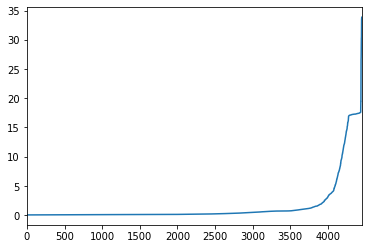

In [118]:
lb.Score.plot();

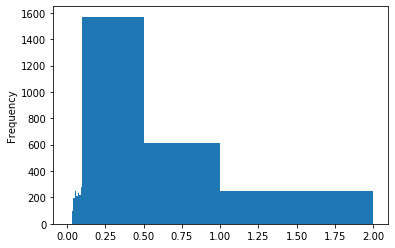

In [119]:
lb.Score.plot.hist(bins=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 1, 2]);

In [120]:
mybestscore = 0.06240  # get your best public LB score after submission

In [121]:
lb[lb.Score <= mybestscore].shape

(602, 4)

In [123]:
602/4453 * 100

13.518975971255335

- so, without much tuning, we're already placed in the top ***15%***, which is not a bad thing :)

## Next steps:

- see if higher image quality increases model accuracy further... parameter `size` for _data_
- hyper param tuning
- play with transformations' params
- play with TTA
- we can train a separate model that recognizes text to predict 0 everytime we see a text image with no cat/dog
    - this'd be the ensemble of models